# 0.0 Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import umap.umap_ as umap
import warnings
warnings.filterwarnings("ignore")

from IPython.display     import HTML
from matplotlib          import pyplot  as plt
from sklearn             import cluster as c
from sklearn             import metrics as m
from plotly              import express as px
from sklearn             import preprocessing as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

/home/soturno/.pyenv/versions/3.10.4/envs/pa05/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/soturno/.pyenv/versions/3.10.4/envs/pa05/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/soturno/.pyenv/versions/3.10.4/envs/pa05

## 0.1. Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

## 0.2. Load dataset

In [3]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')

df_raw

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France,NaN
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France,NaN
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France,NaN
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France,NaN


In [4]:
# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename columuns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.3 Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.4 Replace NA

In [9]:
# remove na
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format(1-( df1.shape[0] / df_raw.shape[0])))

Removed data: 0.25%


In [10]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.5 Change dtypes

In [11]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## <font color='red'> 1.6 Descriptive statistics </font>

# 2.0 Feature engineering 

In [13]:
df2 = df1.copy()

## 2.1 Feature creation

In [14]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates(ignore_index=True)


# Gross Revenue - quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']


# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')


# Recency - Last day of purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')


# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')


# Avg Ticket
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

# <font color='red'> 3.0 Variable filtering </font>

In [262]:
df3 = df_ref.copy()

# <font color='red'> 4.0 EDA (Exploratory Data Analysis) </font>

In [263]:
df4 = df3.copy()

# <font color='red'> 5.0 Data preparation </font>

In [264]:
df5 = df4.copy()

In [265]:
## Standard Scalaer
ssgross = pp.StandardScaler()
ssrecency = pp.StandardScaler()
ssinvoice = pp.StandardScaler()
ssavg = pp.StandardScaler()

df5['gross_revenue'] = ssgross.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ssrecency.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ssinvoice.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ssavg.fit_transform(df5[['avg_ticket']])

# <font color='red'> 6.0 Feature selection </font>

In [241]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [266]:
X = df6.drop(columns=['customer_id'])

clusters = [2, 3, 4, 5, 6,7]

In [267]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.412510,2.088304,3.204704,-0.093381
1,0.143658,-0.601239,1.384124,-0.103129
2,0.643541,-0.889050,1.384124,-0.001604
3,-0.115620,0.033930,-0.008083,0.039487
4,-0.153723,2.366190,0.099010,0.604912


## 7.2 Elbow and silhouette score

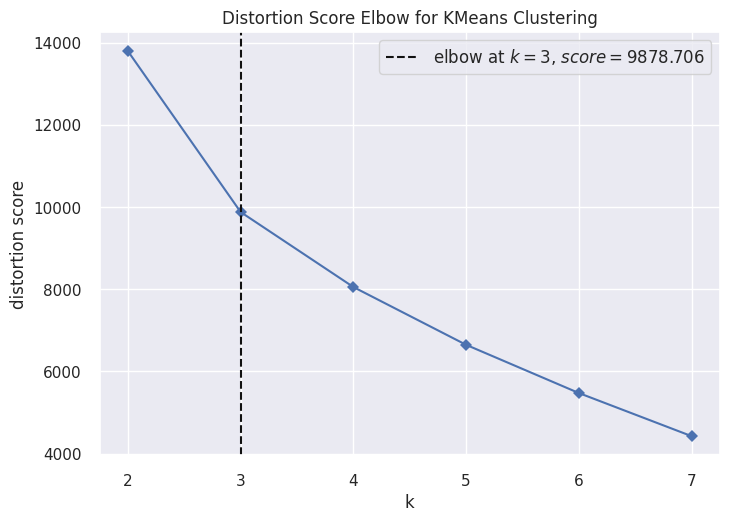

In [276]:
kmeans = KElbowVisualizer(c.KMeans(n_init='auto'),k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

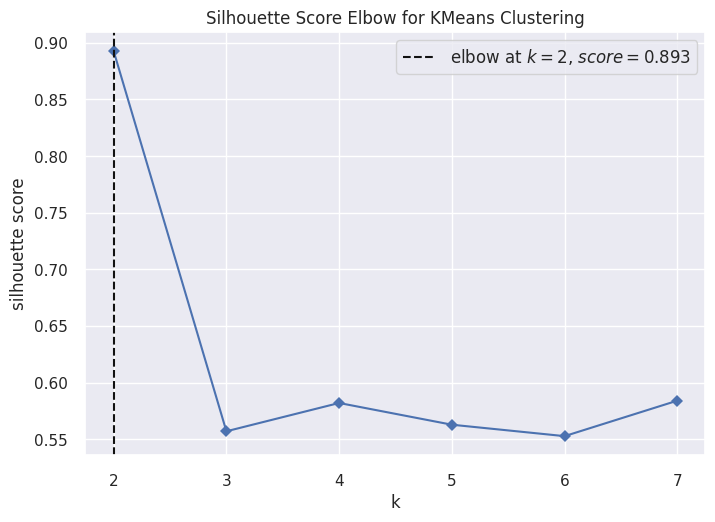

In [277]:
kmeans = KElbowVisualizer( c.KMeans(n_init='auto'), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show();

## 7.2 Silhouette Analysis

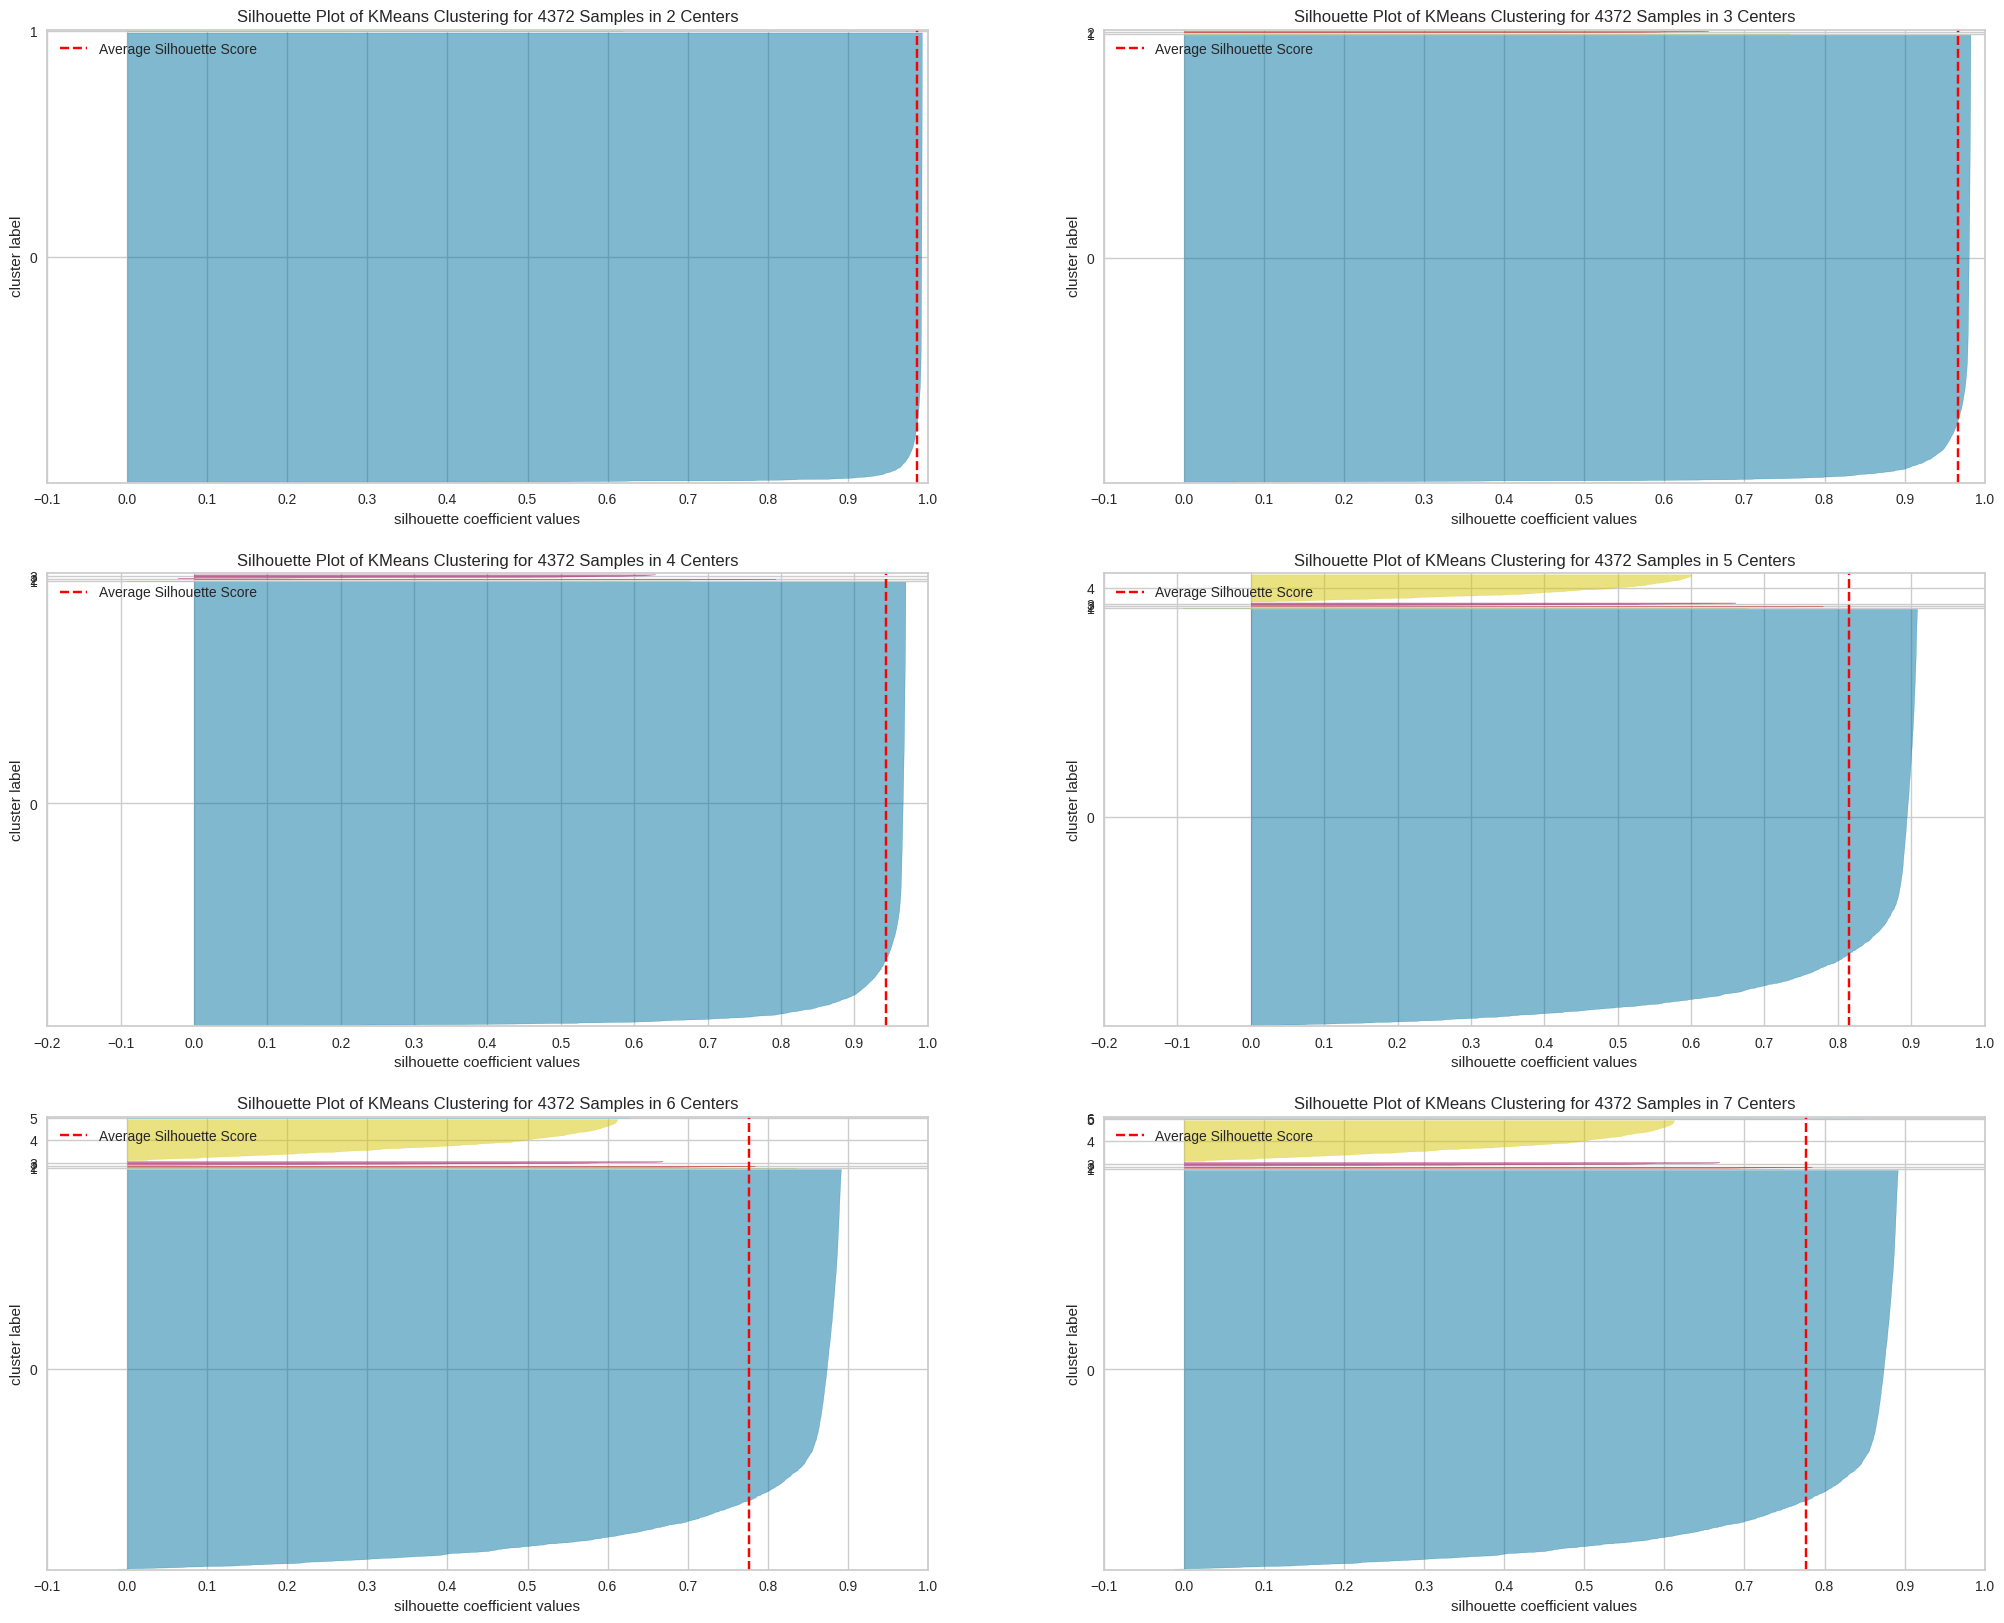

In [23]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 20) )

for k in clusters:
    km = c.KMeans( n_clusters=k, n_init='auto',random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

#  8.0 Model training 

## 8.1 K-Means

In [272]:
# model definition
k = 5

kmeans = c.KMeans(n_clusters=k,random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster validation

In [273]:
## WSS (Within-cluster sum of square)
print('WSS value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score 
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 6561.338598518403
SS value: 0.5782052389710186


# 9.0 Cluster analysis

In [274]:
df9 = df6.copy()
df9['cluster'] = labels

df9['gross_revenue'] = ssgross.inverse_transform(df9[['gross_revenue']])
df9['recency_days'] = ssrecency.inverse_transform(df9[['recency_days']])
df9['invoice_no'] = ssinvoice.inverse_transform(df9[['invoice_no']])
df9['avg_ticket'] = ssavg.inverse_transform(df9[['avg_ticket']])

df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302.0,35.0,16.950737,3
1,13047,3079.10,31.0,18.0,15.709694,0
2,12583,7187.34,2.0,18.0,28.634821,0
3,13748,948.25,95.0,5.0,33.866071,0
4,15100,635.10,330.0,6.0,105.850000,1


## 9.1 Visualization inspection

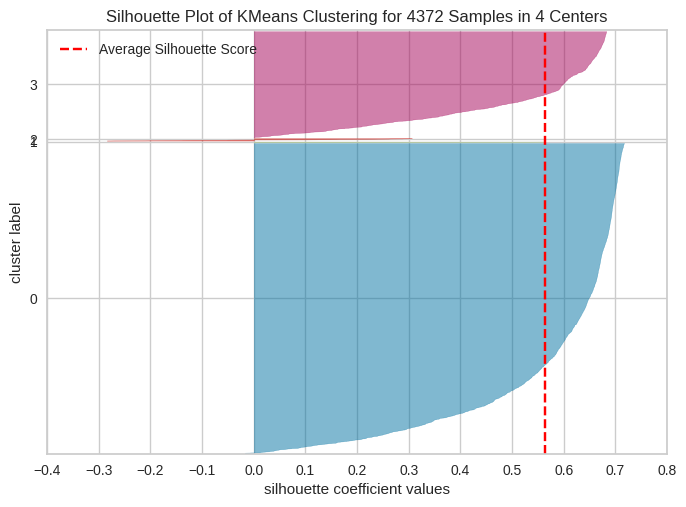

In [247]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d plot

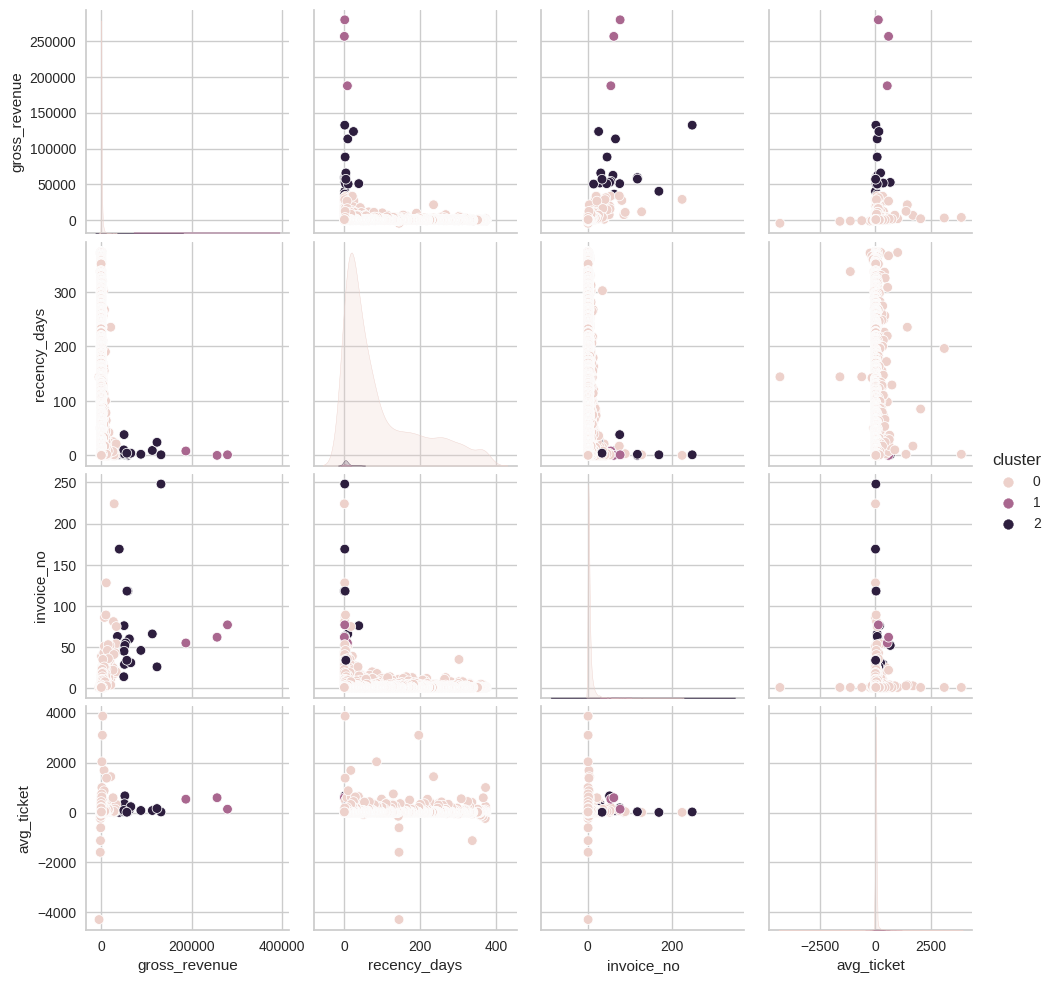

In [115]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster');

## 9.3 UMAP


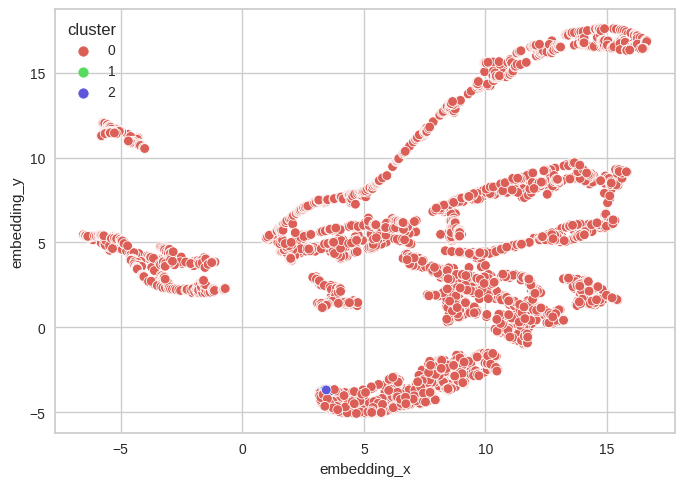

In [255]:
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                 data=df_viz);

## 9.4 Cluster profile

In [275]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,3169,72.483989,1468.876533,41.291890,4.801515,23.450835
1,1,1081,24.725526,438.316310,247.929695,1.806660,27.353742
2,2,6,0.137237,182181.981667,7.166667,89.000000,253.626345
3,3,110,2.516011,18441.961455,8.609091,40.672727,65.338302
4,4,6,0.137237,8278.083333,89.500000,2.166667,2248.350741


### Cluster 01: (Insider Candidate)
    - Number of customers: 2 (0.04% of customers)
    - Average recency: 0.5 days
    - Purchases on average: 69 purchases
    - Average revenue: $267,963.75 USD
        
### Cluster 02:
    - Number of customers: 4 (0.09 of customers)
    - Average recency: 10 days
    - Purchases on average: 98 purchases
    - Average revenue: $139,291.09 USD
        
### Cluster 03:
    - Number of customers: 14 (0.32% of customers)
    - Average recency: 6 days
    - Purchases on average: 65 purchases
    - Average revenue: $55,597.33 USD
    
### Cluster 04:
    - Number of customers: 122 (2.8% of customers)
    - Average recency: 17 days
    - Purchases on average: 28 purchases
    - Average revenue: $13,658.21 USD
    
### Cluster 05:
    - Number of customers: 4230 (96% of customers)
    - Average recency: 94 days
    - Purchases on average: 4 purchases
    - Average revenue: $1125,94 USD

# <font color='red'> 10.0. Deploy To Production </font>